In [1]:

"""
Current Figure 3 from the paper
Example Fit + performance + invariance line 
Use a cortical culture recording from HIH as example
"""
%matplotlib inline

#%% 
import matplotlib.pyplot as plt
from os import listdir 
from os.path import isfile, join
import numpy as np
from scipy.io import loadmat as loadmat
na =np.array
import torch
from src.sbi_helpers import simulatorDurs as simulator
from src.vis.plot import pairplot#, probs2contours
# from src.data_proc.data_utils import read_burst_stat
from sbi.inference import simulate_for_sbi
import seaborn as sns
from sbi import utils as utils
from sbi.simulators.simutils import simulate_in_batches
from sbi.inference import SNPE, SNLE, prepare_for_sbi, simulate_for_sbi

from functools import partial
from src.sbi_helpers import state_checker
from src.sbi_helpers import simulatorDurs as simulator
simulator2=partial(simulator,keys=['b','theta','tau_w','sigma'])
import pandas as pd
#%%
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from src.vis.styling_func import to_inches

import os
os.environ['PATH'] += os.pathsep + '/usr/local/texlive/2024/bin/x86_64-linux'

def plot_angles(slopes,radius,colors):
    angles_rad = np.arctan(slopes)
    x_coords = radius * np.cos(angles_rad)
    y_coords = radius * np.sin(angles_rad)-J/2
    for i in range(len(x_coords)):
        plt.plot( x_coords[i],  y_coords[i], 'o',color = colors[i])

from src.vis.bifurcations import plot_bifurcations
from src.dynamics_Model2 import get_slope

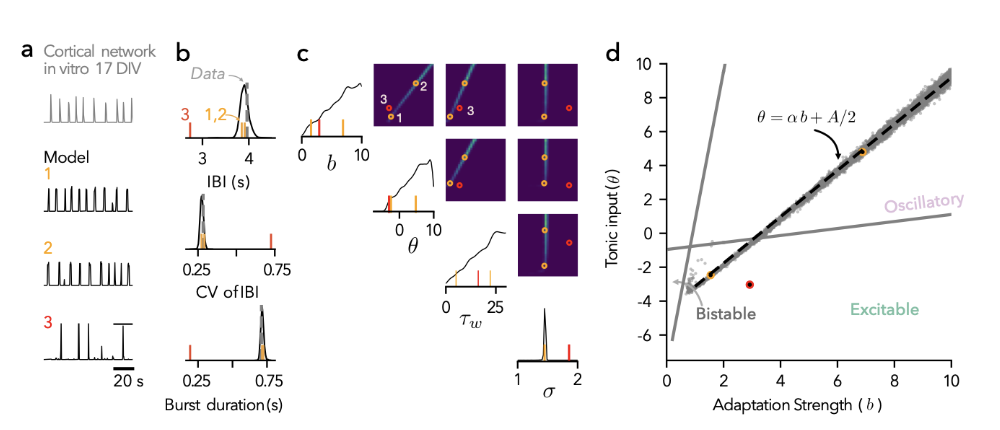

In [2]:
posteriors_nsf_snp = np.load('../../trained/posterior_snp_nsf_14.03.22.npy',allow_pickle=True) # new fit with fixed number of bursts
posterior = posteriors_nsf_snp.item()

In [3]:
# Load spikes
import pickle
file_path = '../../data/CtxHipp/well_spikes_HIH'

# Open the file in binary read mode
with open(file_path, 'rb') as file:
    # Use pickle to load the object from the file
    loaded_data = pickle.load(file)

In [4]:
# data = pd.read_csv('../../data/CtxHipp/HIH_summary_full_single.csv') # Charleseworth
data = pd.read_csv('../../data/CtxHipp/HIH_summary_full_v2024.csv') 

[3.95985417 0.2835238  0.71001554]


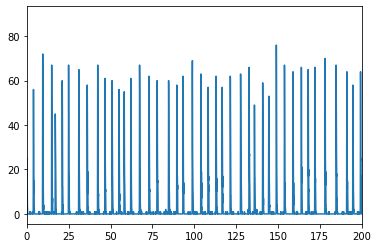

In [5]:
n=13#9,13,16,17(nice!),23
# 12,9 
st,gid = loaded_data[n]
sc,bins = np.histogram(st,np.arange(0,np.max(st),0.05))
plt.plot(bins[1:],sc)
plt.xlim(0,200)
x0 = na(data[['ibi','cvibi','dur']])[n]
print(x0)

/home/ovinogradov/Projects/ReducedBursting/src/vis/plot.py:271: UserWarning: Importing `pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import pairplot`.
  warn(
<ipython-input-6-623fb32ab23b>:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


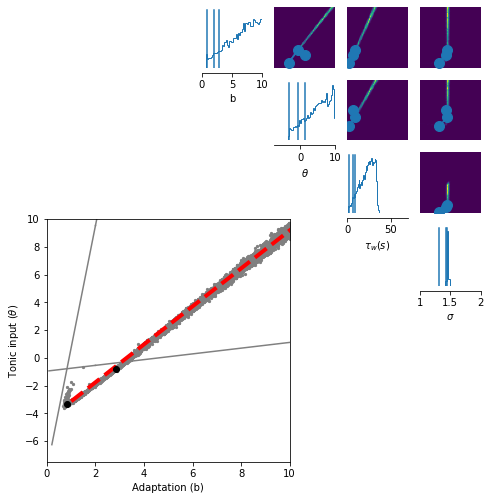

In [6]:
num_dim = 4
# prior = utils.BoxUniform(low=torch.tensor([ .05, -10.,  np.log(200.), 0.01])*torch.ones(num_dim),
#                          high=torch.tensor([ 30.0, 15,  np.log(200000.),2.0])*torch.ones(num_dim))

prior = utils.BoxUniform(low=torch.tensor([ .05, -10.,  np.log(200.), 0.01])*torch.ones(num_dim),
                         high=torch.tensor([ 30.0, 15,  np.log(200000.),.1])*torch.ones(num_dim))

# posterior.prior = prior
min_set =[.0,  -7.5, 0., 1]
max_set= [10.0, 10,  70,2.]


posterior.set_default_x(x0)
samples = posterior.sample((10000,),  show_progress_bars=False)
# samples = samples_ctx
samples[:,1]=-samples[:,1]
samples[:,2]=np.exp(samples[:,2])/1000
# sel_theta = thetas[13,:].numpy().copy()
# sel_theta[1]=-sel_theta[1]
# sel_theta[2]=np.exp(sel_theta[2])/1000
# samples[1][:,1]=-samples[1][:,1]
# samples[1][:,2]=np.exp(samples[1][:,2])/1000
# sel_inds =[80,500,1300]

sel_inds =[50,900]

samples= samples.numpy()
ind_sort= np.argsort(samples[:,0])
samples =samples[ind_sort,:]

#off samples
sampl = samples[500,:].copy()
# sampl[1] = -sampl[1]
# sampl[2] *= 1000
sampl[1]+=3

fig,axis = pairplot(samples,
                limits=np.vstack([min_set,max_set]).T.tolist(),
                upper= 'hist',
                diag='hist',
                # points_colors =# ['#1f77b4', '#ff7f0e', '#2ca02c'],
            #   upper = 'scatter',
                points = [np.vstack([samples[sel_inds,:],sampl])],
                figsize=(5,5),
                labels =('b','$\\theta$','$\\tau_w (s)$','$\sigma$'),)
# plt.savefig('/home/ovinogradov/Projects/ReducedBursting/results/figs/paper_figs/predictive_performance_1.pdf',bbox_inches='tight')
axin = axis[0,0].inset_axes([-2.55, -6.5, 4., 4.])# Plot the data on the inset axis and zoom in on the important part

plot_bifurcations(inverse=1,ax=axin)
cax = axin.scatter(samples[:,0],samples[:,1],s=20,marker='.',color='gray')#c = samples[:,2],cmap='gray_r')#$'flare')
axin.set_xlim([min_set[0],max_set[0]])
axin.set_ylim([min_set[1],max_set[1]])
# axin.set_ylim(-5,5)
# clb = plt.colorbar(cax,ax=axin,anchor=(1.2,1))
# clb.ax.set_title('$\\tau_w$ (s) ')


slope = get_slope(x0[0],x0[2],9)
bs = np.arange(1,40,0.1)

a = 5
# tau_w = x0[0]*(a*)
thetas  = (bs*slope -4.5)# - (-2/a + J/4)*(x0[2]/tau_w)

axin.plot(bs,thetas,'--r',linewidth = 4)

axin.set_xlabel('Adaptation (b)')
axin.set_ylabel('Tonic input ($\\theta$)')


for ind in sel_inds:
    axin.plot(samples[ind,0],samples[ind,1],'ok')
    
    
sampl = samples[500,:].copy()
# sampl[1] = -sampl[1]
# sampl[2] *= 1000
sampl[1]-=7
sampl[0]-=2
axin.plot(sampl[0],sampl[1],'or')

# axis[0,0].indicate_inset_zoom(axin)

# plot_data(axin)
# axin.set_xlim(-10, 12)
# axin.set_ylim(0.75, 1.4)# Add the lines to indicate where the inset axis is coming from
# axis.indicate_inset_zoom(axin)
plt.tight_layout()
# plt.savefig('../../results/BC23-figures/invariance.pdf',bbox_inches='tight')#,papertype='A0')

In [7]:

selected_samples = []
for ind in sel_inds:
    # axin.plot(samples[ind,0],samples[ind,1],'ok')
    selected_samples.append(samples[ind,:].copy())
    
sampl = samples[500,:].copy()
# sampl[1] = -sampl[1]
# sampl[2] *= 1000
sampl[1]-=5
sampl[0]-=2
sampl[3]+=.4
selected_samples.append(sampl.copy())
# axin.plot(sampl[0],sampl[1],'or')

------GT------
median 0.21722782
1853.6649
98
----Bursts-----
3.867268041237113 0.25224590303872696 0.702857142857143
median 0.2386497
9373.012
95
----Bursts-----
3.998404255319149 0.29179414838550977 0.7245263157894738
median 0.0026082562
6643.128
0


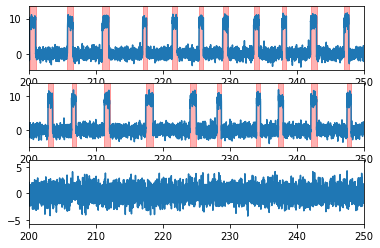

In [8]:


from src.dynamics_Model2 import StochSim_o
from src.helpers import spike_burst_det
from src.helpers import reduce_params,expand_params
print('------GT------')

burst_detection_params={'maxISIstart':10.,
                    'maxISIb':10.,
                    'minBdur':17.,
                    'minIBI':20.,
                    'minSburst':17.,
                    'scale':10.
                    }

res = []
example_sum= [] 
example_par = []
np.random.seed(123456789)
for i,sampl in enumerate(selected_samples):#:enumerate(sel_inds):#[150,800,1600]):
    sampl_ =sampl.copy() #samples[i,:].copy()
    sampl_[1] = -sampl[1]
    # sampl[1] = -sampl[1]
    # sampl[1] = -(sampl[0]*get_slope(x0[0],x0[1]) - 4.5)
    sampl_[2] *= 1000
    sampl_[2] = np.log(sampl_[2])
    # print(sampl)
    plt.subplot(3,1,i+1)
    # sampl = samples[sorted_ind[ind],:].numpy()
    # sampl = posterior.sample((1,), x=x_os[i]).numpy()[0]
    params = expand_params(sampl_,T=600000,torch_=False,keys=['b','theta','tau_w','sigma'])
    example_par.append(sampl_)
    params['x0']=0
    
    t_dyn,x_dyn,w_dyn = StochSim_o(params,torch=0)
    print('median',np.median(x_dyn))
    cut = int(len(t_dyn)/4)
    print(params['tau_w'])
    dt= np.diff(t_dyn[cut::100])[0] 
    # x_transform = 10/(1+np.exp(-1*x_dyn[cut::100]+9))

    # bursts= na(spike_burst_det(x_dyn,dt,burst_detection_params))
    # bursts = detect_derivat(x_dyn[cut:],dt)
    bursts= na(spike_burst_det(x_dyn[cut::100],dt,burst_detection_params))
    bursts = bursts+0.05*cut
    res.append([t_dyn[cut:],x_dyn[cut:],w_dyn[cut:]])
    print(len(bursts))
    if len(bursts)>2:
        durs = np.diff(bursts)/1000
        ibis =(bursts[1:,0]-bursts[:-1,1])/1000
        mibi = np.mean(ibis)
        mdur = np.mean(durs)
        cv_ibis = np.std(ibis)/mibi
        cv_dur = np.std(durs)/mdur
        print('----Bursts-----')
        print(mibi,cv_ibis,mdur)
        example_sum.append([mibi,cv_ibis,mdur])
        # example_par.append(sampl)
        for b_ in bursts:
            plt.axvspan(b_[0]/1000,b_[1]/1000,alpha=0.3,color='r')
    plt.plot(t_dyn[::200]/1000,x_dyn[::200])
    # x_transform = 10/(1+np.exp(-1*x_dyn[::200]+4.5))
    # plt.plot(t_dyn[::200]/1000,x_transform-i*15)

        # plt.plot(b_[0]/1000,-i*15,'xk')
        # plt.plot(b_[1]/1000,-(i+1)*15,'xr')
    plt.xlim(200,250)


In [9]:
from sklearn import linear_model
def get_poisson_coef(sc,x_dyn):
    clf = linear_model.PoissonRegressor(fit_intercept=False)
    X= x_dyn
    X =X[X>4.5]
    y= sc
    y = y[y>50]
    lent = min([len(X),len(y)])
    clf.fit(X[:lent].reshape((lent,1)), y[:lent])
    return clf.coef_



[3.95985417 0.2835238  0.71001554]


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by PoissonRegressor.

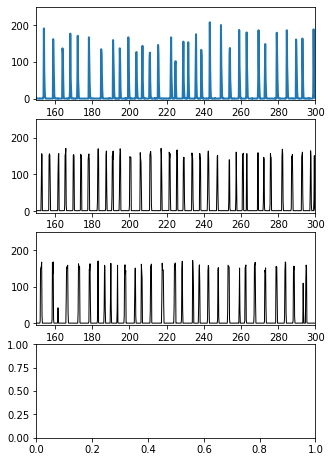

In [10]:
plt.figure(figsize=(5,10))
plt.subplot(5,1,1)
# n= 5
factor = 12*0.1#64*0.1  # To Hz (per neuron/per channel)
st,gid = loaded_data[n]

binsize = 0.2
sc,bins = np.histogram(st,np.arange(0,np.max(st),binsize))

plt.plot(bins[1:],sc/factor,linewidth=2)
plt.xlim([150,300])
plt.ylim(-5,250)
# x0 = na(example_summary[['ibi','cvibi','dur']])[n]
print(x0)

for i,m in enumerate(res): 
    plt.subplot(5,1,i+2)
    
    t_dyn,x_dyn,w_dyn = m
    bin_size_ms = int((binsize*1000)/0.05) #(s*1000)/dt
    t = res[i][0][::bin_size_ms]
    # x_dyn = res[i][1][::2000]# binsize! 100ms
    
    activity = res[i][1]
    activity = activity.reshape(len(res[i][1])//bin_size_ms,bin_size_ms)
    activity = activity.mean(1)
    
    k1 = get_poisson_coef(sc,activity)
    
    sc_ = np.exp(k1*activity[:])
    # sc_  = x_dyn
    sc_ = sc_#/np.median(sc_)
    
    # plt.plot(t[:]/1000,sc_[:]/factor,color='k',linewidth=1)
    plt.plot(t[:]/1000,sc_[:],color='k',linewidth=1)
    
    plt.xlim([150,300])
    plt.ylim(-5,250)
plt.xlabel('t [s]')

# plt.savefig('../../results/BC23-figures/example_traces.pdf',bbox_inches='tight')#,papertype='A0')

In [11]:

# check the performance 
from src.helpers import simulator_summaryN as simulator
# from src.helpers_model4 import simulator_summaryN as simulator
n=2000
paramters =torch.tensor([0,0,0,0])
identities = []
sampl = posterior.sample((n,), x=x0)#.numpy()
# sampl[:,3]+=torch.tensor(np.random.normal(0,0.05,size=(sampl.shape[0])))
# paramters = torch.tensor(np.vstack([paramters,sampl]))
# paramters = paramters[1:,:]
num_dim = 4


prior = utils.BoxUniform(low=torch.tensor([ .05,-1.,  np.log(200.), 0.1])*torch.ones(num_dim),
                         high=torch.tensor([ 20.0, 15,  np.log(200000.),2.0])*torch.ones(num_dim))
# Get the 50 first samples 
# paramters = torch.tensor(np.vstack([]))
simulator2=partial(simulator,param_keys=['b','theta','tau_w','sigma'],
                                          burst_detection_params={'maxISIstart':10.,
                                                'maxISIb':10.,
                                                'minBdur':10.,
                                                'minIBI':10.,
                                                'minSburst':7.,#17.,
                                                'scale':10.}
                  
                  )

simulator2, prior = prepare_for_sbi(simulator2, prior)
%time xs = simulate_in_batches(simulator2,torch.tensor(sampl),sim_batch_size=1, num_workers=20)
xs_ = xs.numpy().copy()

names = ['ctx']#, 'hipp', 'hPSC']

xs_df = pd.DataFrame(xs_,columns=['ibi','cvibi','dur','cvdur','r1','r2'])
xs_df['culture_type'] = np.hstack([[name]*n for name in names])#[[n]*100 for n in names[:-1]][0]#['ctx']*100+['hipp']*100
xs_df['model']='model'
# for i,par in enumerate(['b','theta','tau_w','sigma']):
    # xs_df[par] = paramters[:,i]

xs_df['Category']='sim'


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

SystemError: CPUDispatcher(<function run_sim_o at 0x7f00a0b3bc10>) returned a result with an error set

In [216]:
# xs_df['params'] = sampl

In [217]:
colors = na([[242,164,58],
             [242,164,58],
             [234,67,37]])/255

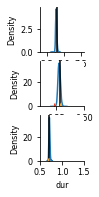

In [221]:
def mm_to_inch(x):
    return x/25.4

plt.figure(figsize= (mm_to_inch(20),mm_to_inch(72)))
limits = [[1.5,8],[.1,.5],[0.5,1.5]]
summary = ['ibi','cvibi','dur']
for i,summ in enumerate(summary):
    plt.subplot(3,1,1+i)
    sns.kdeplot(x=summ,data=xs_df)
    # sns.histplot(x=summ,data=xs_df,bins=50)
    # plt.hist()
    # sns.violinplot(y=summ,data=xs_df,color='gray')
    # sns.swarmplot(y=summ,data=xs_df)
    plt.axvline(x0[i],color='k')
    # plt.xlim([-1,1])
    plt.xlim(limits[i])
    # plt.plot(xs_[ind1,i],0,'o',color=colors[1])
    # plt.plot(xs_[ind2,i],0,'o',color=colors[1])
    plt.plot(example_sum[0][i],0,'|',color=colors[1])
    plt.plot(example_sum[1][i],0,'|',color=colors[1])
    plt.plot(example_sum[-1][i],0,'|',color=colors[2])
    sns.despine()
    # for i_,s in enumerate(example_sum):
    #     plt.axvline(s[i],color=colors[i_])
    # sns.despine()
    
colors = na([[242,164,58],
             [242,164,58],
             [234,67,37]])/255
    # color = ['']

# plt.savefig('../../results/figs/paper_figs/performance2_hist.pdf',bbox_inches='tight')#,papertype='A0')

In [384]:
samples = posterior.sample((10000,),  show_progress_bars=False)

/home/ovinogradov/Projects/ReducedBursting/src/vis/plot.py:271: UserWarning: Importing `pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import pairplot`.
  warn(


Text(150, 220, '3')

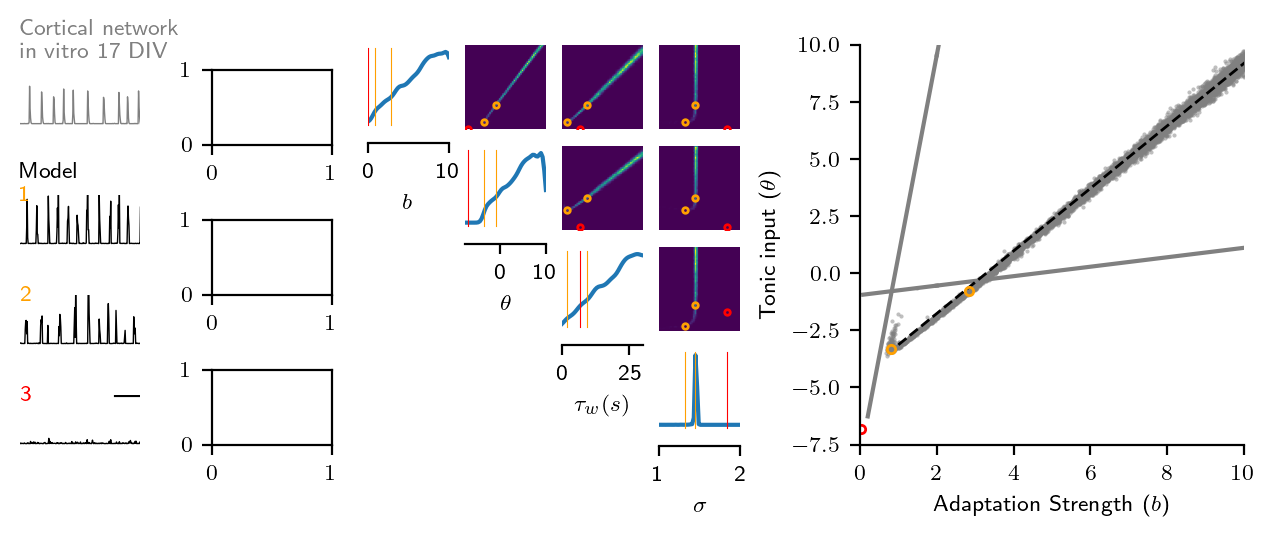

In [13]:
def _get_fig_kwargs():
    """Get default figure kwargs."""
    return {
        "legend": None,
        "legend_kwargs": {},
        # labels
        "points_labels": [f"points_{idx}" for idx in range(10)],  # for points
        "samples_labels": [f"samples_{idx}" for idx in range(10)],  # for samples
        # colors: take even colors for samples, odd colors for points
        "samples_colors":plt.rcParams["axes.prop_cycle"].by_key()["color"][0::2],  # pyright: ignore[reportOptionalMemberAccess]
        "points_colors":['#FFA000','#FFA000','r'], #plt.rcParams["axes.prop_cycle"].by_key()["color"][1::2],  # pyright: ignore[reportOptionalMemberAccess]
        # ticks
        # "tickformatter": mpl.ticker.FormatStrFormatter("%g"),  # type: ignore
        "tick_labels": None,
        # formatting points (scale, markers)
        "points_diag": {'linewidth':0.4},
        "points_offdiag": {
            "marker": "o",
            "markersize": 2,
            "markerfacecolor":"None",
        },
        # other options
        "fig_bg_colors": {"offdiag": None, "diag": None, "lower": None},
        "fig_subplots_adjust": {
            "top": .9,
        },
        "subplots": {},
        "despine": {
            "offset": 5,
        },
        "title": None,
        "title_format": {"fontsize": 16},
        "x_lim_add_eps": 1e-5,
        "square_subplots": True,
    }
import matplotlib
matplotlib.rcParams.update({'font.size': 8})
min_set =[.0,  -7.5, 0., 1]
max_set= [10.0, 10,  30,2.]

from matplotlib import rc
import matplotlib.pylab as plt
plt.rcParams['text.usetex'] = True


from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)


# Generate the figure with sbi pairplot
fig,axis = pairplot(samples,
                limits=np.vstack([min_set,max_set]).T.tolist(),
                upper= 'hist',
                diag='kde',
                # points_colors =# ['#1f77b4', '#ff7f0e', '#2ca02c'],
            #   upper = 'scatter',
                points = selected_samples,#list(np.vstack([samples[sel_inds,:],sampl])),
                figsize=(2.4,2.5),
                labels =('$b$','$\\theta$','$\\tau_w (s)$','$\\sigma$'),
                **_get_fig_kwargs(),
                linewidth=0.5
                   )
fig.dpi=200
# Add axes 
axes = {}
axes['hist3'] =fig.add_subplot(1,1,1,position=[-.2, 0.1, 0.25, 0.15])
axes['hist2'] =fig.add_subplot(1,1,1,position=[-.2, .4, 0.25, 0.15])
axes['hist1'] =fig.add_subplot(1,1,1,position=[-.2, .7, 0.25, 0.15])

axes['trace4'] = fig.add_subplot(1,1,1,position=[-.6, 0.1, 0.25, 0.1])
axes['trace3'] = fig.add_subplot(1,1,1,position=[-.6, .3, 0.25, 0.1])
axes['trace2'] = fig.add_subplot(1,1,1,position=[-.6, .5, 0.25, 0.1])
axes['trace1'] = fig.add_subplot(1,1,1,position=[-.6, .74, 0.25, 0.1])

axes['zoom_in'] = fig.add_subplot(1,1,1,position=[1.15, 0.1, .8, .8])


# Zoom in 
point_colors = ['#FFA000','#FFA000','r']
plot_bifurcations(inverse=1,ax=axes['zoom_in'])
cax = axes['zoom_in'].scatter(samples[:,0],samples[:,1],s=1,marker='.',color='gray',alpha=0.5)#c = samples[:,2],cmap='gray_r')#$'flare')
axes['zoom_in'].set_xlim([min_set[0],max_set[0]])
axes['zoom_in'].set_ylim([min_set[1],max_set[1]])

a = 5
# tau_w = x0[0]*(a*)
thetas  = (bs*slope -4.5)# - (-2/a + J/4)*(x0[2]/tau_w)

axes['zoom_in'].plot(bs,thetas,'--k',linewidth = 1)

for i,sample in enumerate(selected_samples):
    axes['zoom_in'].plot(sample[0],sample[1],
                                     marker= "o",
                                    markersize= 3,
                                     markerfacecolor="None",
                                     color=point_colors[i])
sns.despine(ax=axes['zoom_in'])
axes['zoom_in'].set_xlabel('Adaptation Strength ($b$)')
axes['zoom_in'].set_ylabel('Tonic input  ($\\theta$)')

axes['trace1'].set_title('Cortical network \n in vitro 17 DIV',fontsize=8,loc='left',color='gray')
axes['trace1'].axis('off')



axes['trace2'].set_title('Model',fontsize=8,loc='left')
axes['trace2'].axis('off')
# fig


#========Histograms======
# 5.267597402597403 0.421952774457645 0.5098076923076922
# limits = [[3,6],[.1,.5],[0.4,.8]]

# eps = na([1,0.2,0.5])
# limits = (na([np.min(na(example_sum),0),np.max(na(example_sum),0)])+eps).T

# summary = ['ibi','cvibi','dur']
# axis_ = [axes['hist1'],axes['hist2'],axes['hist3']]
# xlabels = ['IBI (s)','CV of IBI','Burst duration (s)']
# for i,summ in enumerate(summary):
#     # plt.subplot(3,1,1+i)
#     sns.kdeplot(x=summ,data=xs_df,ax=axis_[i],color='k',linewidth=0.75)
#     axis_[i].axvline(x0[i],color='gray',linestyle='--')
#     axis_[i].plot(example_sum[0][i],0,'|',color=colors[1],markersize=15,linewidth=10)
#     axis_[i].plot(example_sum[1][i],0,'|',color=colors[1],markersize=15,linewidth=10)
#     axis_[i].plot(example_sum[-1][i],0,'|',color=colors[2],markersize=15,linewidth=10)
#     axis_[i].set_ylabel('')
#     axis_[i].set_xlabel(xlabels[i])
#     axis_[i].set_yticks([])
#     sns.despine(ax=axis_[i],left=1)

    
# =====TRACES
n=13

factor = 12*0.1#64*0.1  # To Hz (per neuron/per channel)
st,gid = loaded_data[n]
binsize = 0.2
sc,bins = np.histogram(st,np.arange(0,np.max(st),binsize))
axes['trace1'].plot(bins[1:],sc/factor,linewidth=.5,color='gray')
axes['trace1'].set_xlim([150,200])
axes['trace1'].set_ylim(-5,250)

for i,m in enumerate(res): 
    t_dyn,x_dyn,w_dyn = m
    bin_size_ms = int((binsize*1000)/0.05) #(s*1000)/dt
    t = res[i][0][::bin_size_ms]
    activity = res[i][1][::bin_size_ms]
    # activity = res[i][1]
    # activity = activity.reshape(len(res[i][1])//bin_size_ms,bin_size_ms)
    # activity = activity.mean(1)
    
    k1 = get_poisson_coef(sc,activity)
    
    sc_ = np.exp(k1*activity[:])
    
    # plt.plot(t[:]/1000,sc_[:]/factor,color='k',linewidth=1)
    axes['trace%s'%int(i+2)].plot(t[:]/1000,sc_[:],color='k',linewidth=.5)
    axes['trace%s'%int(i+2)].set_xlabel(xlabels[i])
    axes['trace%s'%int(i+2)].set_xlim([150,200])
    axes['trace%s'%int(i+2)].set_ylim(-5,250)
    axes['trace%s'%int(i+2)].axis('off')
    
axes['trace4'].plot([190,200],[250,250],'-k')
# axes['trace%s'%3].set_.xlabel('t [s]')

axes['trace2'].text(150,220,'1',color=point_colors[0])
axes['trace3'].text(150,220,'2',color=point_colors[0])
axes['trace4'].text(150,220,'3',color=point_colors[2])

# plt.savefig('../../results/figs/paper_figs/Fig3_mpl_.pdf',bbox_inches='tight',)#)

In [392]:
selected_samples

[array([ 1.5455018, -2.4669104,  5.099062 ,  1.4424394], dtype=float32),
 array([ 6.8809776,  4.7953863, 22.17861  ,  1.4485965], dtype=float32),
 array([ 2.9198036, -3.0304418, 16.191036 ,  1.8574542], dtype=float32)]